In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
import tensorflow_datasets as tfds

ds_train, info = tfds.load('mnist', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('mnist', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('mnist', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

In [2]:
import tensorflow as tf

def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.expand_dims(image, axis=-1)  # Expand dimensions to match MNIST grayscale images
    label = tf.one_hot(label, nclasses)
    return image, label


In [3]:
batch_size = 1024

train_data = ds_train.map(preprocess)
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {}".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

X_test, Y_test = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test)

print("X test batch shape = {}, Y test batch shape = {}".format(X_test.shape, Y_test.shape))

2020-05-20 15:21:00.165417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


X train batch shape = (1024, 28, 28, 1, 1), Y train batch shape = (1024, 10)
X test batch shape = (10000, 28, 28, 1, 1), Y test batch shape = (10000, 10)


In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model


x = x_in = Input(input_shape)

filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(int(f), kernel_size=(3, 3), strides=(1, 1), kernel_initializer='lecun_uniform',
               kernel_regularizer=l1(0.0001), use_bias=False, name='conv_{}'.format(i))(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)

x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)

x = Dense(n_classes, name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layer_size = np.prod(w.shape)
        print("{}: {}".format(layer.name, layer_size))  # 0 = weights, 1 = biases
        if layer_size > 4096:
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layer_size))

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 26, 26, 16)        144       
_________________________________________________________________
bn_conv_0 (BatchNormalizatio (None, 26, 26, 16)        64        
_________________________________________________________________
conv_act_0 (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 13, 13, 16)        0         
_______________________________

In [6]:
train = True  

n_epochs = 30

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True
    )

    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    ]

    start = time.time()
    model.fit(
        train_data,
        epochs=n_epochs,
        validation_data=val_data,
        callbacks=callbacks,
    )
    end = time.time()

    print('It took {} minutes to train the Keras model'.format((end - start) / 60.))

    model.save('cnn_mnist_u250.h5')


Epoch 1/30
53/53 [==============================] - 6s 96ms/step - loss: 1.2759 - accuracy: 0.6372 - val_loss: 0.9630 - val_accuracy: 0.9228
Epoch 2/30
53/53 [==============================] - 5s 87ms/step - loss: 0.2554 - accuracy: 0.9543 - val_loss: 1.2494 - val_accuracy: 0.6357
Epoch 3/30
53/53 [==============================] - 5s 83ms/step - loss: 0.1956 - accuracy: 0.9707 - val_loss: 1.3130 - val_accuracy: 0.6167
Epoch 4/30
53/53 [==============================] - 5s 83ms/step - loss: 0.1690 - accuracy: 0.9787 - val_loss: 0.9865 - val_accuracy: 0.7307

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 5/30
53/53 [==============================] - 5s 84ms/step - loss: 0.1501 - accuracy: 0.9828 - val_loss: 0.5218 - val_accuracy: 0.8662
Epoch 6/30
53/53 [==============================] - 5s 83ms/step - loss: 0.1407 - accuracy: 0.9846 - val_loss: 0.3243 - val_accuracy: 0.9257
Epoch 7/30
53/53 [==============================] - 5s 83ms/step - loss: 0

In [7]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

predict_baseline    = model.predict(X_test)
test_score_baseline = model.evaluate(X_test, Y_test)

print('Accuracy = {}'.format(test_score_baseline[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.1183 - accuracy: 0.9817
Accuracy = 0.9817000031471252


In [19]:
import hls4ml
import plotting


hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1


for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
    
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=hls_config,
                                                       backend='VivadoAccelerator',
                                                       board='alveo-u250',
                                                       io_type='io_stream',
                                                       output_dir='mnist_u250/')

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D,

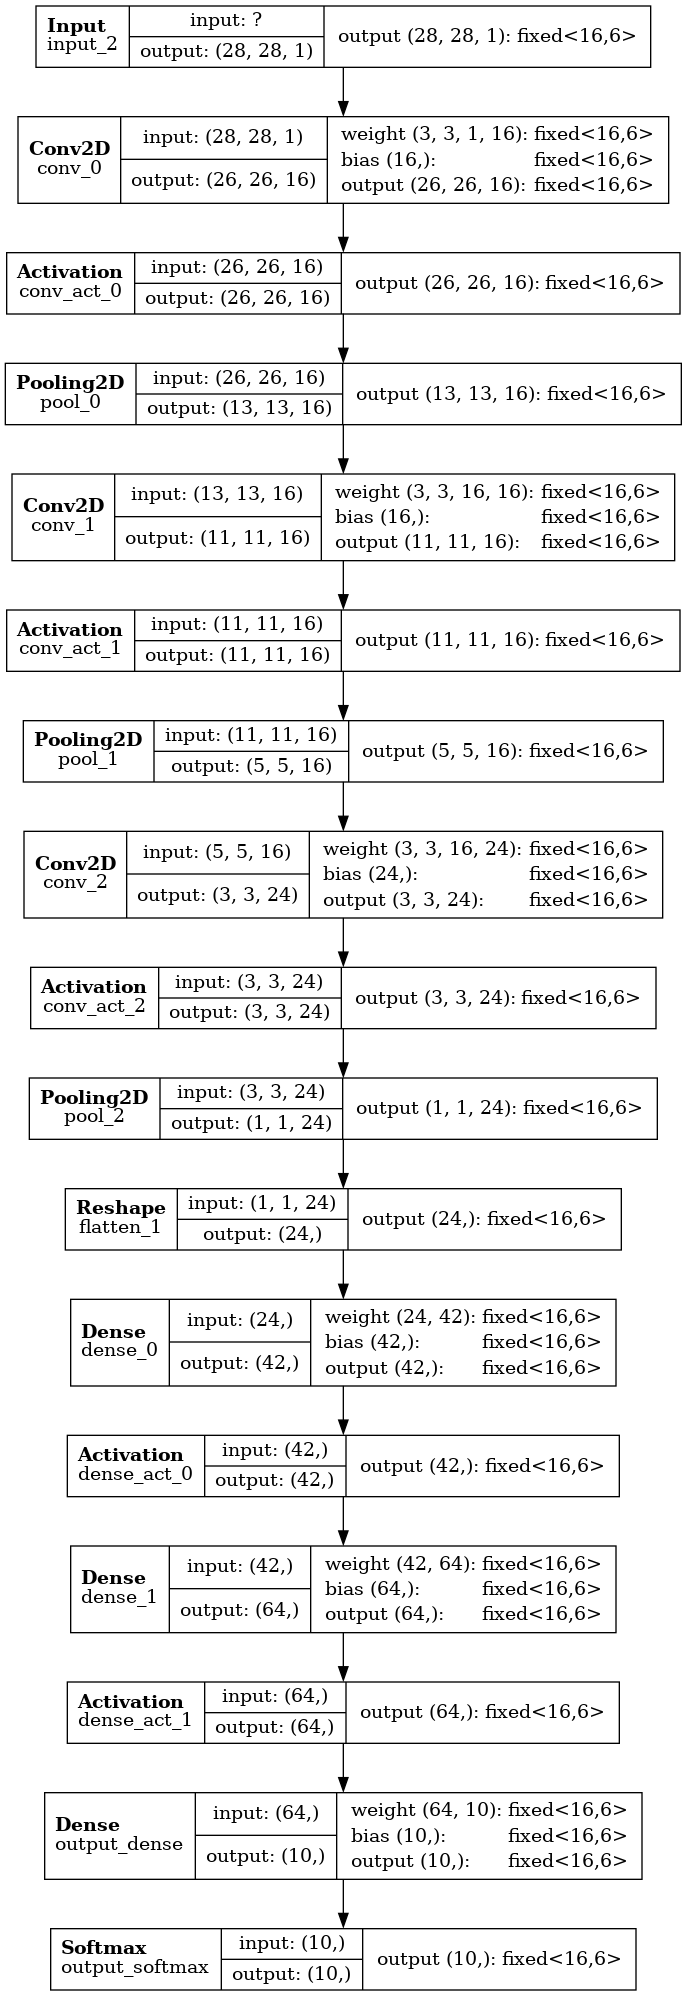

In [20]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls_model.build(csim=False, export=True)

Writing HLS project
Done

****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /home/denis/Xilinx_2020_1/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/denis/Xilinx_2020_1/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'denis' on host 'COS-6PRIME-2955.science.purdue.edu' (Linux_x86_64 version 3.10.0-1160.83.1.el7.x86_64) on Wed May 20 15:42:48 EDT 2020
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/home/denis/Documents/HLS4ML/hls4ml-tutorial/mnist_u250'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/denis/Documents/HLS4ML/hls4ml-tutorial/mnist_u250/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproj

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:41 ; elapsed = 00:00:43 . Memory (MB): peak = 1751.340 ; gain = 1231.883 ; free physical = 157087 ; free virtual = 180932
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2020.1/continuous/2020_05_27_2902540/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2020.1/continuous/2020_05_27_2902540/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2020.1/continuous/2020_05_27_2902540/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754

INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:44 ; elapsed = 00:00:46 . Memory (MB): peak = 1751.340 ; gain = 1231.883 ; free physical = 157051 ; free virtual = 180902
INFO: [XFORM 203-1101] Packing variable 'out_pack.data.V' (firmware/nnet_utils/nnet_activation_stream.h:240) into a 160-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 1024-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 672-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 384-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 256-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_ac

INFO: [HLS 200-489] Unrolling loop 'SoftmaxArrayPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:207) in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config28>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Loop-2' (firmware/nnet_utils/nnet_activation_stream.h:218) in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config28>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Loop-3' (firmware/nnet_utils/nnet_activation_stream.h:227) in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config28>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'SoftmaxInvPack

INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 24u>, config12>' completely with a factor of 24.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 24u>, config12>' completely with a factor of 24.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 24u>, config12>' completely with a factor of 144.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet:

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>' completely with a factor of 42.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 24u>, config16>' completely with a factor of 24.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 24u>, config16>' completely with a factor of 24.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 24u>, config16>' completely with a factor of 1.
INFO: [H

INFO: [XFORM 203-102] Partitioning array 'd_xi_xmax.V' (firmware/nnet_utils/nnet_activation_stream.h:217) automatically.
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.5' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.4' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.3' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.2' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.1' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V' .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer26_out.V.data.V' (firmware/myproject.cpp:111) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'out_local.V.data.V' (firmware/myproject_axi.cpp:15) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'lay

INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2020.1/continuous/2020_05_27_2902540/src/products/hls/hls_lib/hlsmath/include/FloatingPoi

INFO: [XFORM 203-721] Changing loop 'Loop_1_proc' (firmware/myproject_axi.cpp:20) to a process function for dataflow in function 'myproject_axi'.
INFO: [XFORM 203-721] Changing loop 'Loop_2_proc' (firmware/myproject_axi.cpp:34) to a process function for dataflow in function 'myproject_axi'.
INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 15 process function(s): 
	 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config5>'
	 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>'
	 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6,

In [ ]:
hls_model.config.backend.make_xclbin(hls_model)